# 4.4 E Dataset Modeling

<div class="alert alert-block alert-info">
<b>Results:</b> This dataset did not out-perform the AE dataset.
    
Go straight to [Results](#Results) for E Dataset
</div>

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Creating the Network of Best Model


In [2]:
#shaping X_train and X_test
train_data_dir = "../datasets/train_cropped_e/train"
validation_data_dir = "../datasets/train_cropped_e/val"
filepath = "../models/best_model_e_cp.hdf5"

img_rows, img_cols = 48, 48
num_classes = 4
epochs = 100
batch_size = 64

In [3]:
#callbacks

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_categorical_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=0,
                          mode='auto',
                          patience=15,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                              factor=0.2,
                              mode='auto',
                              patience=5,
                              verbose=1,
                              min_delta=0.001)

# callbacks = [checkpoint]
callbacks = [earlystop,checkpoint,reduce_lr]

In [4]:
#data augmentation for train dataset, normalize all 

val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
        rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 19601 images belonging to 4 classes.
Found 4198 images belonging to 4 classes.


In [5]:
global train_samples, validation_samples
train_samples = 19601
validation_samples = 4198


print(validation_generator.class_indices)

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}


In [6]:
#Model
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape= (48,48,1)))
model.add(Conv2D(16, kernel_size=(3, 3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4, activation="softmax"))


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [7]:
#compile model
model.compile(optimizer= Adam(lr=0.001, decay=1e-6),
              loss="categorical_crossentropy",
              metrics=["categorical_accuracy"])

In [8]:
%%time

#fit model
history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
306/306 [==============================] - ETA: 0s - loss: 1.2657 - categorical_accuracy: 0.4052
Epoch 00001: val_categorical_accuracy improved from -inf to 0.48005, saving model to ../models/best_model_e_cp.hdf5
306/306 [==============================] - 49s 161ms/step - loss: 1.2657 - categorical_accuracy: 0.4052 - val_loss: 1.2064 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/100
306/306 [==============================] - ETA: 0s - loss: 1.1282 - categorical_accuracy: 0.5305
Epoch 00002: val_categorical_accuracy improved from 0.48005 to 0.60889, saving model to ../models/best_model_e_cp.hdf5
306/306 [==============================] - 51s 167ms/step - loss: 1.1282 - categorical_accuracy: 0.5305 - val_loss: 0.9614 - val_categorical_accuracy: 0.6089 - lr: 0.0010
Epoch 3/100
306/306 [==============================] - ETA: 0s - loss: 1.0283 - categorical_accuracy: 0.5767
Epoch 00003: val_cat

Epoch 22/100
306/306 [==============================] - ETA: 0s - loss: 0.6702 - categorical_accuracy: 0.7376
Epoch 00022: val_categorical_accuracy did not improve from 0.75986
306/306 [==============================] - 51s 167ms/step - loss: 0.6702 - categorical_accuracy: 0.7376 - val_loss: 0.6387 - val_categorical_accuracy: 0.7488 - lr: 0.0010
Epoch 23/100
306/306 [==============================] - ETA: 0s - loss: 0.6681 - categorical_accuracy: 0.7378
Epoch 00023: val_categorical_accuracy did not improve from 0.75986
306/306 [==============================] - 50s 163ms/step - loss: 0.6681 - categorical_accuracy: 0.7378 - val_loss: 0.6284 - val_categorical_accuracy: 0.7519 - lr: 0.0010
Epoch 24/100
306/306 [==============================] - ETA: 0s - loss: 0.6598 - categorical_accuracy: 0.7438
Epoch 00024: val_categorical_accuracy did not improve from 0.75986
306/306 [==============================] - 50s 163ms/step - loss: 0.6598 - categorical_accuracy: 0.7438 - val_loss: 0.6198 - va

306/306 [==============================] - ETA: 0s - loss: 0.5536 - categorical_accuracy: 0.7882
Epoch 00044: val_categorical_accuracy did not improve from 0.78101
306/306 [==============================] - 49s 161ms/step - loss: 0.5536 - categorical_accuracy: 0.7882 - val_loss: 0.5566 - val_categorical_accuracy: 0.7810 - lr: 2.0000e-04
Epoch 45/100
306/306 [==============================] - ETA: 0s - loss: 0.5529 - categorical_accuracy: 0.7889
Epoch 00045: val_categorical_accuracy improved from 0.78101 to 0.78245, saving model to ../models/best_model_e_cp.hdf5
306/306 [==============================] - 49s 161ms/step - loss: 0.5529 - categorical_accuracy: 0.7889 - val_loss: 0.5717 - val_categorical_accuracy: 0.7825 - lr: 2.0000e-04
Epoch 46/100
306/306 [==============================] - ETA: 0s - loss: 0.5492 - categorical_accuracy: 0.7898
Epoch 00046: val_categorical_accuracy did not improve from 0.78245
306/306 [==============================] - 49s 160ms/step - loss: 0.5492 - categ

Epoch 66/100
306/306 [==============================] - ETA: 0s - loss: 0.5336 - categorical_accuracy: 0.7945
Epoch 00066: val_categorical_accuracy did not improve from 0.78582
306/306 [==============================] - 28s 92ms/step - loss: 0.5336 - categorical_accuracy: 0.7945 - val_loss: 0.5537 - val_categorical_accuracy: 0.7849 - lr: 8.0000e-06
Epoch 67/100
306/306 [==============================] - ETA: 0s - loss: 0.5262 - categorical_accuracy: 0.8006
Epoch 00067: val_categorical_accuracy did not improve from 0.78582
306/306 [==============================] - 28s 91ms/step - loss: 0.5262 - categorical_accuracy: 0.8006 - val_loss: 0.5515 - val_categorical_accuracy: 0.7846 - lr: 8.0000e-06
Epoch 68/100
306/306 [==============================] - ETA: 0s - loss: 0.5276 - categorical_accuracy: 0.8008
Epoch 00068: val_categorical_accuracy improved from 0.78582 to 0.78606, saving model to ../models/best_model_e_cp.hdf5
306/306 [==============================] - 28s 91ms/step - loss: 0.52

## Results

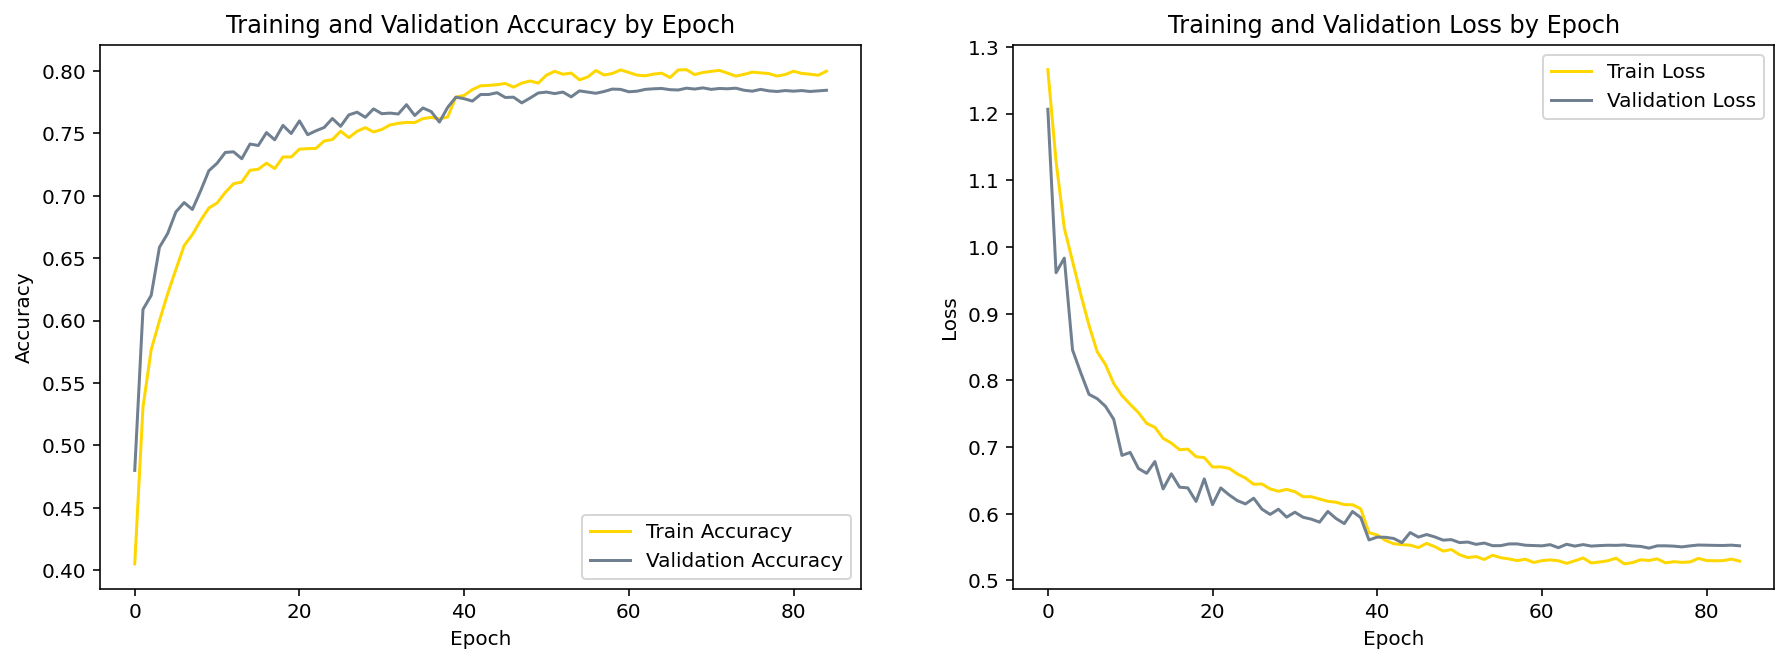

In [9]:
#plotting Accuracy and Loss curves
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history["categorical_accuracy"], label = 'Train Accuracy', color='gold')
plt.plot(history.history["val_categorical_accuracy"], label = 'Validation Accuracy', color='slategray')
plt.title("Training and Validation Accuracy by Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

plt.subplot(122)
plt.plot(history.history["loss"], label = 'Train Loss', color='gold')
plt.plot(history.history["val_loss"], label = 'Validation Loss', color='slategray')
plt.title("Training and Validation Loss by Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Found 4198 images belonging to 4 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
Classification Report
              precision    recall  f1-score   support

       angry       0.71      0.69      0.70       544
       happy       0.89      0.89      0.89      1665
     neutral       0.75      0.82      0.78      1401
         sad       0.64      0.49      0.56       588

    accuracy                           0.79      4198
   macro avg       0.74      0.72      0.73      4198
weighted avg       0.78      0.79      0.78      4198



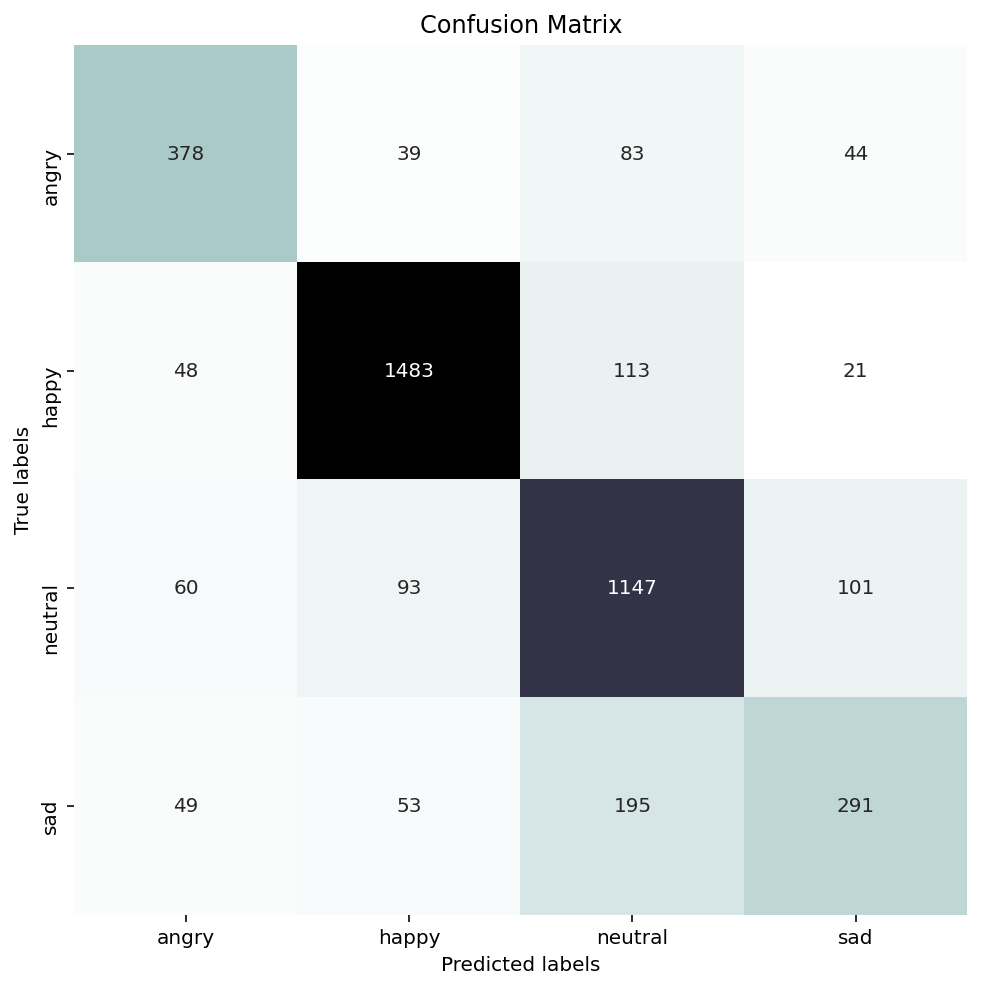

In [10]:
#Code snippet credit: APEKSHA PRIYA, Priya Dwivedi
#confusion matrix and classification report

#validation generator with shuffle = false
validation_generator1 = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator1.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confusion Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator1, validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_test = validation_generator1.classes

#Generate Confusion Matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix.ravel

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_test, y_pred, target_names=target_names))


#plot confusion matrix
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap='bone_r', fmt='g', cbar=False)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['angry', 'happy', 'neutral', 'sad'])
ax.yaxis.set_ticklabels(['angry', 'happy', 'neutral', 'sad']);